# Melanoma Detection Using CNNs

####

**Business Problem**:

To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import glob
import PIL
from skimage import io
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom, RandomContrast
from keras_cv.layers import AugMix, RandAugment, RandomShear
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array

Using TensorFlow backend


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [2]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("./Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("./Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [3]:
image_count_train = len(list(data_dir_train.glob("*/*.jpg")))
print("Train image count = ",image_count_train)
image_count_test = len(list(data_dir_test.glob("*/*.jpg")))
print("Test image count = ",image_count_test)

Train image count =  2239
Test image count =  118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [4]:
batch_size = 32
img_height = 180
img_width = 180
channels = 3
input_shape = (180,180,3)
num_classes = 9

Use 80% of the images for training, and 20% for validation.

In [5]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=data_dir_train,
    image_size=(img_height,img_width),
    batch_size=batch_size,
    seed=123,
    validation_split=0.2,
    subset='training',
    shuffle=True
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [6]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=data_dir_train,
    image_size=(img_height,img_width),
    batch_size=batch_size,
    seed=123,
    validation_split=0.2,
    subset='validation',
    shuffle=True
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [7]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

Using the training dataset to visualize. Ran a for loop over the TF dataset and plotted the first occurrence of an image from each class while going class by clas.

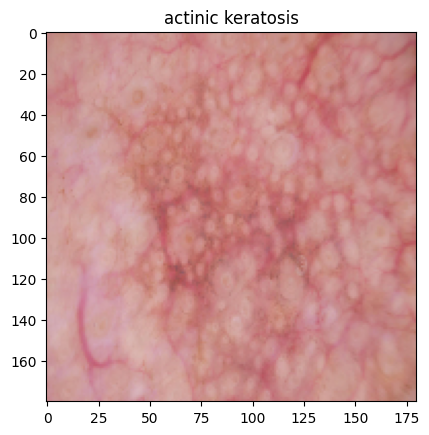

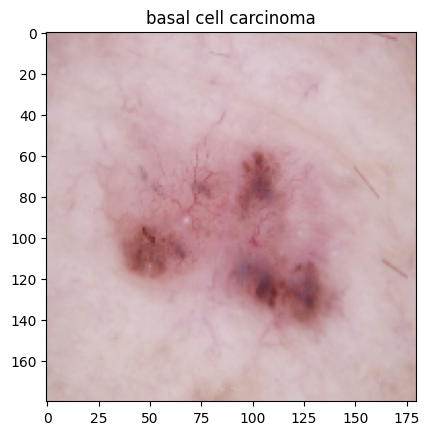

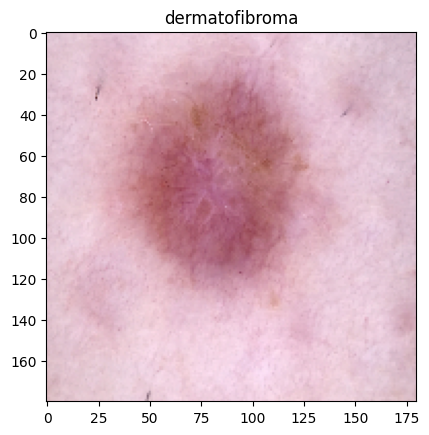

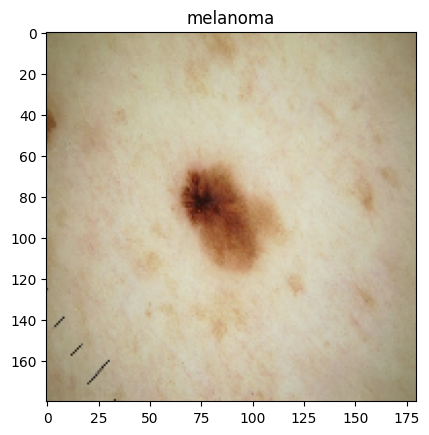

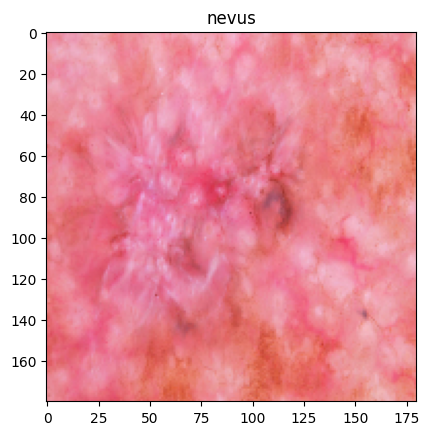

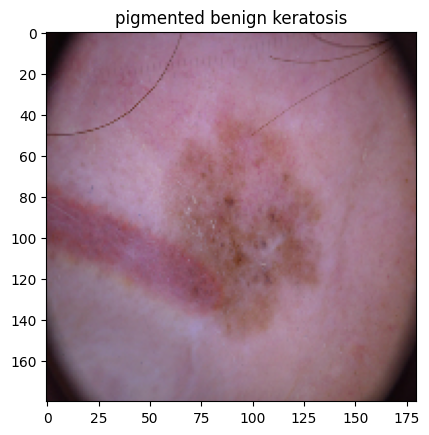

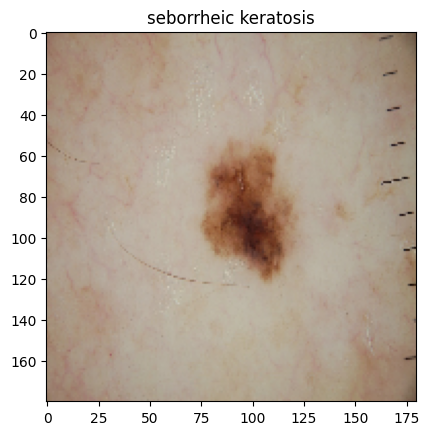

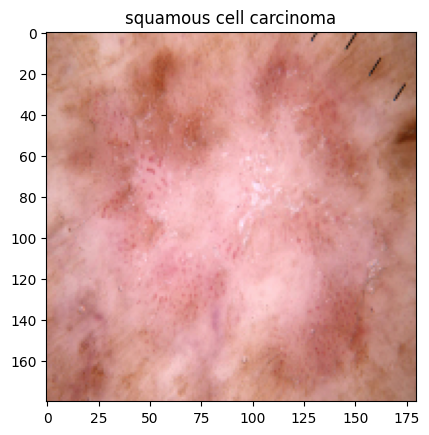

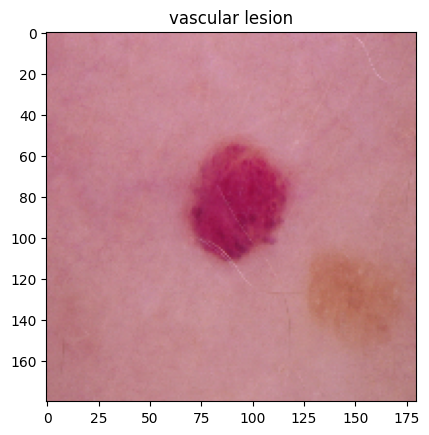

In [8]:
### your code goes here, you can use training or validation data to visualize
curr_cls = 0
for img_batch,label_batch in train_ds:
    for i in range(32):
        label = label_batch.numpy()[i]
        img = img_batch[i]
        if label == curr_cls:
            plt.title(class_names[curr_cls])
            plt.imshow(img.numpy().astype('int'))
            plt.show()
            curr_cls = curr_cls+1
    if curr_cls == 9:
        break

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

### Building a base model first to set the benchmark

The base model simply contains the basic layers & processes that a CNN based model should have. Want to get a feel of how things maybe in this problem statement. The performance of the base model will set the path for further additions and modifications.

In [10]:
### Simple base model

model_0 = Sequential()
model_0.add(Rescaling(scale=1./255,input_shape=input_shape))

model_0.add(Conv2D(32,kernel_size=(3,3),padding='same',activation='relu'))
model_0.add(Conv2D(64,kernel_size=(3,3),padding='same',activation='relu'))
model_0.add(MaxPooling2D(pool_size=(2,2)))
model_0.add(Dropout(0.25))

# flatten and put a fully connected layer
model_0.add(Flatten())
model_0.add(Dense(64, activation='relu'))
model_0.add(Dropout(0.25))
model_0.add(Dense(num_classes, activation='softmax'))

# model summary
model_0.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 90, 90, 64)        0         
                                                                 
 flatten (Flatten)           (None, 518400)            0         
                                                        

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [11]:
### Todo, choose an appropirate optimiser and loss function
model_0.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Train the model

Running for only 10 epochs to test the model out.

In [12]:
history_0 = model_0.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
56/56 [==============================] - 41s 663ms/step - loss: 6.2152 - accuracy: 0.1925 - val_loss: 1.9595 - val_accuracy: 0.2103
Epoch 2/10
56/56 [==============================] - 35s 623ms/step - loss: 1.9070 - accuracy: 0.3069 - val_loss: 1.8409 - val_accuracy: 0.3154
Epoch 3/10
56/56 [==============================] - 34s 606ms/step - loss: 1.7753 - accuracy: 0.3750 - val_loss: 1.6774 - val_accuracy: 0.4407
Epoch 4/10
56/56 [==============================] - 37s 659ms/step - loss: 1.6578 - accuracy: 0.4169 - val_loss: 1.6443 - val_accuracy: 0.4720
Epoch 5/10
56/56 [==============================] - 37s 652ms/step - loss: 1.4533 - accuracy: 0.4939 - val_loss: 1.5282 - val_accuracy: 0.5078
Epoch 6/10
56/56 [==============================] - 35s 631ms/step - loss: 1.3841 - accuracy: 0.5134 - val_loss: 1.5956 - val_accuracy: 0.4720
Epoch 7/10
56/56 [==============================] - 36s 637ms/step - loss: 1.2834 - accuracy: 0.5525 - val_loss: 1.5474 - val_accuracy: 0.4855

#### Learnings -
Obviosuly, this model was too simple. Around the 5th epoch, the validation accuracy plateaued and remained flat in further epochs while the training accuracy kept on increasing. This is a poor model.

### Building the first proper model by making changes to the base model by trial and error.

Various iterations were tried following a data-driven process of addition/modifications dictated by the model results. Below model is what we are going with.

In [13]:
# Starting CNN Sequential Model Architecture
model_1 = Sequential()

# Taking input and rescaling 
model_1.add(Rescaling(scale=1./255,input_shape=input_shape))

# First Convolutional Layer
model_1.add(Conv2D(32,kernel_size=(3,3),padding='same',activation='relu'))
model_1.add(MaxPooling2D(pool_size=(2,2)))
model_1.add(Dropout(0.25))
# Second Convolutional Layer
model_1.add(Conv2D(64,kernel_size=(3,3),padding='same',activation='relu'))
model_1.add(MaxPooling2D(pool_size=(2,2)))
model_1.add(Dropout(0.25))
# Third Convolutional Layer
model_1.add(Conv2D(128,kernel_size=(3,3),padding='same',activation='relu'))
model_1.add(MaxPooling2D(pool_size=(2,2)))
model_1.add(Dropout(0.25))

# Flatten
model_1.add(Flatten())

# Fully connected layers
model_1.add(Dense(128,activation='relu'))
model_1.add(Dropout(0.25))

model_1.add(Dense(64,activation='relu'))
model_1.add(Dropout(0.25))

# Final Dense Output Layer with Softmax activation
model_1.add(Dense(num_classes,activation='softmax'))

# model summary
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 90, 90, 32)        0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 90, 90, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 45, 45, 64)        0         
 g2D)                                                 

In [14]:
model_1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
# Running for 20 epochs as per the ask
history_1 = model_1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=20
)

Epoch 1/20
56/56 [==============================] - 16s 278ms/step - loss: 2.2885 - accuracy: 0.1847 - val_loss: 2.0958 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 15s 267ms/step - loss: 2.0595 - accuracy: 0.1758 - val_loss: 2.0283 - val_accuracy: 0.2416
Epoch 3/20
56/56 [==============================] - 15s 270ms/step - loss: 2.0523 - accuracy: 0.2109 - val_loss: 2.0357 - val_accuracy: 0.1745
Epoch 4/20
56/56 [==============================] - 16s 283ms/step - loss: 1.9561 - accuracy: 0.2656 - val_loss: 1.9856 - val_accuracy: 0.2170
Epoch 5/20
56/56 [==============================] - 15s 271ms/step - loss: 1.8598 - accuracy: 0.3136 - val_loss: 1.7856 - val_accuracy: 0.3803
Epoch 6/20
56/56 [==============================] - 15s 270ms/step - loss: 1.7579 - accuracy: 0.3477 - val_loss: 1.6585 - val_accuracy: 0.4228
Epoch 7/20
56/56 [==============================] - 15s 271ms/step - loss: 1.6803 - accuracy: 0.3878 - val_loss: 1.8658 - val_accuracy: 0.3065

### Visualizing training results

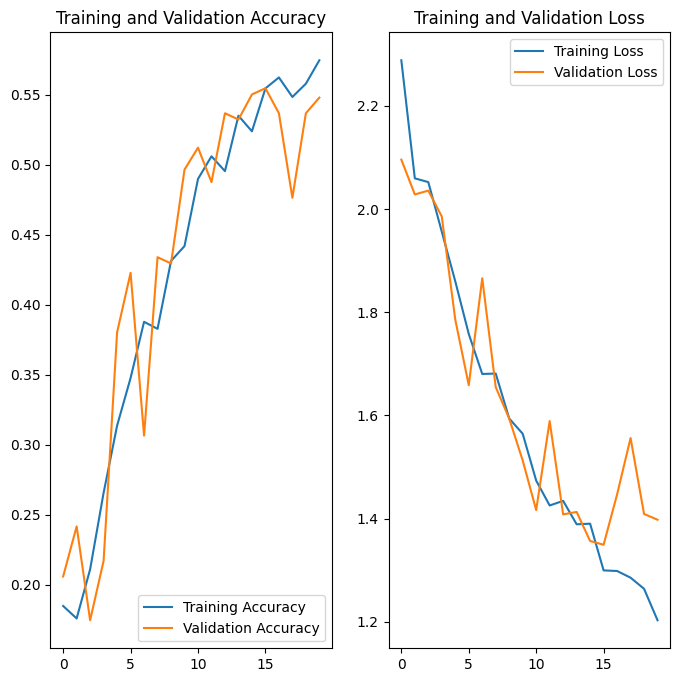

In [16]:
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']

loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

#### Findings -
1. Even after 20 epochs of training, both the training and validation accuracies are in the 50-60% range. Hence, this is an underfit model and not useful for predictions.
2. The validation accuracy peaked around the 13th epoch and then kept fluctuating around the 53% value indicating that it wouldn't have gotten better with more epochs.
3. The train accuracy was still climbing gradually, at a decreasing rate, and could have reached much higher values with more epochs. But that would only make this an overfitted model as the validation accuracy wouldn't have increased.

### Data Augmentation

In [17]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, 
# choose an appropriate data augumentation strategy. 

# Data augmentation using random flip, rotation, zoom, and contrast.

data_augmentation = Sequential(
  [
    RandomFlip("horizontal_and_vertical",input_shape=input_shape),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomContrast(0.1)
  ]
)

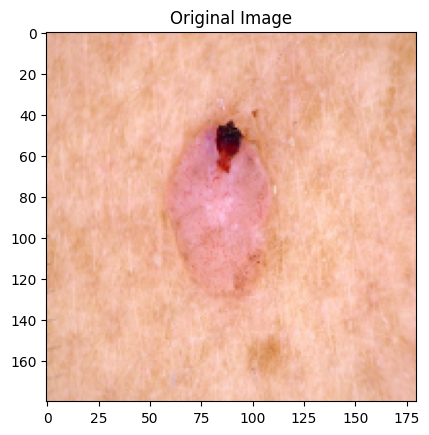

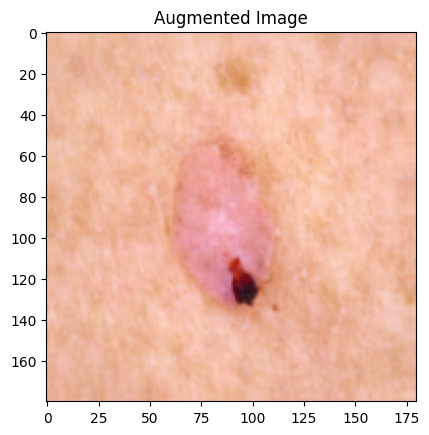

In [18]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
for img_batch,label_batch in train_ds:
    augmented_batch = data_augmentation(img_batch)
    plt.title("Original Image")
    plt.imshow(img_batch[0].numpy().astype('int'))
    plt.show()
    plt.title("Augmented Image")
    plt.imshow(augmented_batch[0].numpy().astype('int'))
    plt.show()
    break    

### Todo:
### Create the model, compile and train the model


In [19]:
# Starting CNN Sequential Model Architecture
model_2 = Sequential()

# Taking input and rescaling 
model_2.add(Rescaling(scale=1./255,input_shape=input_shape))

# Adding augmentation layer
model_2.add(data_augmentation)

# First Convolutional Layer
model_2.add(Conv2D(32,kernel_size=(3,3),padding='same',activation='relu'))
model_2.add(MaxPooling2D(pool_size=(2,2)))
model_2.add(Dropout(0.25))
# Second Convolutional Layer
model_2.add(Conv2D(64,kernel_size=(3,3),padding='same',activation='relu'))
model_2.add(MaxPooling2D(pool_size=(2,2)))
model_2.add(Dropout(0.25))
# Third Convolutional Layer
model_2.add(Conv2D(128,kernel_size=(3,3),padding='same',activation='relu'))
model_2.add(MaxPooling2D(pool_size=(2,2)))
model_2.add(Dropout(0.25))

# Flatten
model_2.add(Flatten())

# Fully connected layers
model_2.add(Dense(128,activation='relu'))
model_2.add(Dropout(0.25))

model_2.add(Dense(64,activation='relu'))
model_2.add(Dropout(0.25))

# Final Dense Output Layer with Softmax activation
model_2.add(Dense(num_classes,activation='softmax'))

# model summary
model_2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 90, 90, 32)        0         
 g2D)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 90, 90, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 90, 90, 64)        18496     
                                                      

### Compiling the model

In [20]:
model_2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Training the model

In [21]:
## Your code goes here, note: train your model for 20 epochs
history_2 = model_2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=20
)

Epoch 1/20
56/56 [==============================] - 17s 294ms/step - loss: 2.1708 - accuracy: 0.2165 - val_loss: 2.0581 - val_accuracy: 0.3535
Epoch 2/20
56/56 [==============================] - 16s 285ms/step - loss: 1.8945 - accuracy: 0.3013 - val_loss: 1.7641 - val_accuracy: 0.2998
Epoch 3/20
56/56 [==============================] - 16s 283ms/step - loss: 1.8081 - accuracy: 0.3438 - val_loss: 1.6644 - val_accuracy: 0.4385
Epoch 4/20
56/56 [==============================] - 16s 280ms/step - loss: 1.6951 - accuracy: 0.3750 - val_loss: 1.5958 - val_accuracy: 0.4609
Epoch 5/20
56/56 [==============================] - 16s 283ms/step - loss: 1.6790 - accuracy: 0.3862 - val_loss: 1.6391 - val_accuracy: 0.4139
Epoch 6/20
56/56 [==============================] - 16s 289ms/step - loss: 1.6383 - accuracy: 0.3951 - val_loss: 1.5708 - val_accuracy: 0.4497
Epoch 7/20
56/56 [==============================] - 16s 282ms/step - loss: 1.6241 - accuracy: 0.4074 - val_loss: 1.5831 - val_accuracy: 0.4452

### Visualizing the results

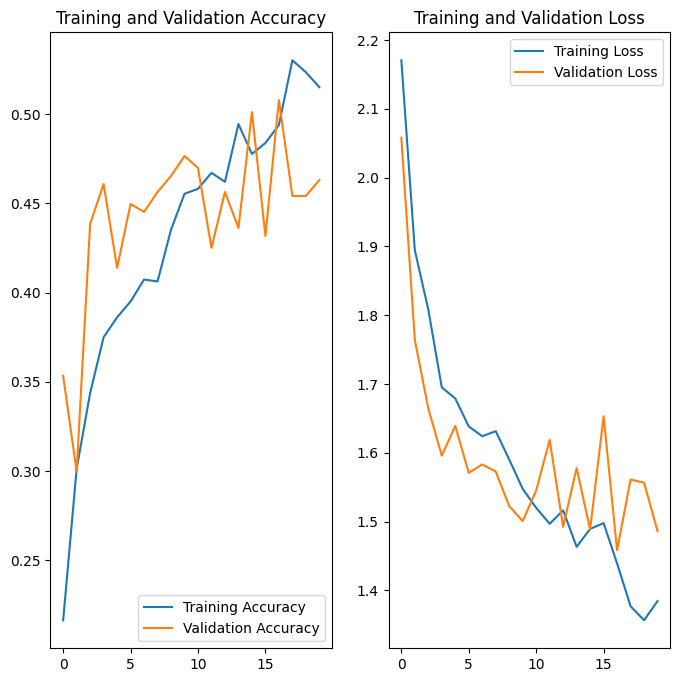

In [22]:
acc = history_2.history['accuracy']
val_acc = history_2.history['val_accuracy']

loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### Findings -
1. Even this one isn't a good model since, even after 20 epochs of training, both the training and validation accuracies are around 50%. Hence, this is an underfit model and not useful for predictions.
2. The validation accuracy peaked around the 10th epoch and then kept fluctuating in the 45-50% range indicating that it wouldn't have gotten better with more epochs.
3. The model is pretty much same as the previous model in terms of results indicating that the augmentations didn't work well. Possibly, adding more training images and fixing the class imbalance is more useful than these augmentations in this case.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [23]:
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

In [24]:
class_counts = []
for name in class_names:
    class_counts.append(len(list(data_dir_train.glob(name+'/*.jpg'))))
class_counts

[114, 376, 95, 438, 357, 462, 77, 181, 139]

In [25]:
class_dist = pd.DataFrame({'class_name':class_names, 'class_count':class_counts})
class_dist

,class_name,class_count
0,actinic keratosis,114
1,basal cell carcinoma,376
2,dermatofibroma,95
3,melanoma,438
4,nevus,357
5,pigmented benign keratosis,462
6,seborrheic keratosis,77
7,squamous cell carcinoma,181
8,vascular lesion,139


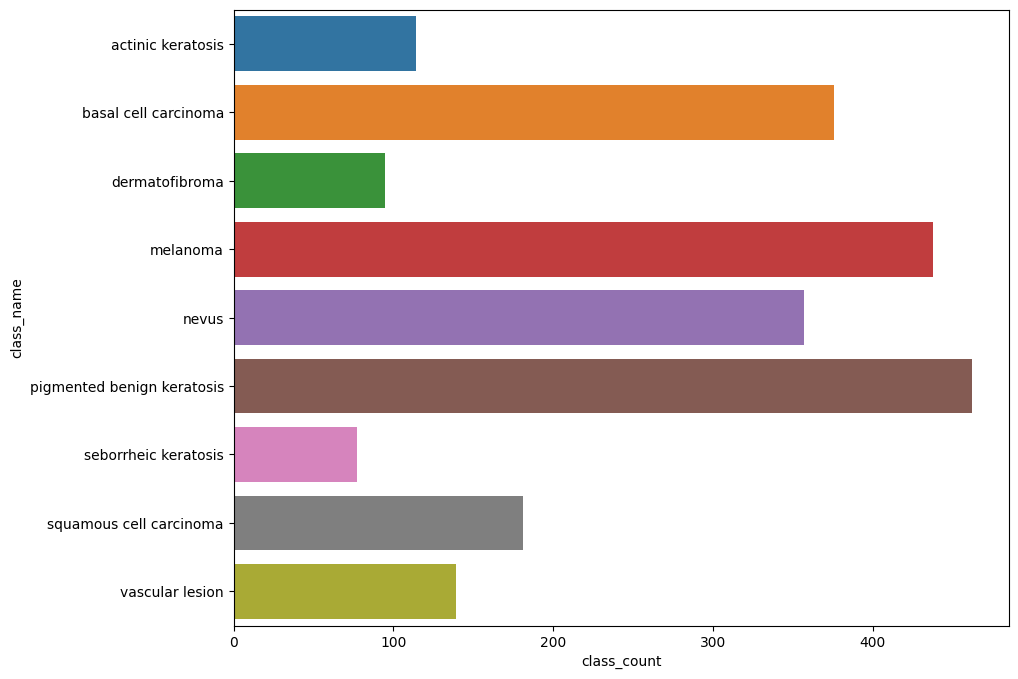

In [26]:
#Visualize the Number of image in each class.
plt.figure(figsize=(10, 8))
sns.barplot(data=class_dist,x='class_count',y="class_name")
plt.show()

#### Findings -
#### - Which class has the least number of samples?
Answer -> 'seborrheic keratosis' has only 77 samples which is the minimum.
#### - Which classes dominate the data in terms proportionate number of samples?
Answer -> 'pigmented benign keratosis' and 'melanoma' are the most dominant classes closely followed by 'basal cell carcinoma' and 'nevus'.

There is a clear class imbalance which would have impacted the model learning.

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [27]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [28]:
path_to_training_dataset="./Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to ./Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2C7AAB590>: 100%|███████████████████| 500/500 [00:01<00:00, 382.61 Samples/s]


Initialised with 376 image(s) found.
Output directory set to ./Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x2C084FF10>: 100%|█| 500/500 [00:01<00:00, 384.44 Samples/s]


Initialised with 95 image(s) found.
Output directory set to ./Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2C0725210>: 100%|███████████████████| 500/500 [00:01<00:00, 386.54 Samples/s]


Initialised with 438 image(s) found.
Output directory set to ./Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=2816x2112 at 0x2C062E550>: 100%|██████████████████| 500/500 [00:05<00:00, 83.56 Samples/s]


Initialised with 357 image(s) found.
Output directory set to ./Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=3072x2304 at 0x2C0645D10>: 100%|█| 500/500 [00:05<00:00, 99.06 Samples/s


Initialised with 462 image(s) found.
Output directory set to ./Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2C078F8D0>: 100%|███████████████████| 500/500 [00:01<00:00, 379.70 Samples/s]


Initialised with 77 image(s) found.
Output directory set to ./Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x2C05FB050>: 100%|██████████████████| 500/500 [00:02<00:00, 169.53 Samples/s]


Initialised with 181 image(s) found.
Output directory set to ./Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2C07EA590>: 100%|███████████████████| 500/500 [00:01<00:00, 374.93 Samples/s]


Initialised with 139 image(s) found.
Output directory set to ./Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2C7A70690>: 100%|███████████████████| 500/500 [00:01<00:00, 370.48 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types. Lets take a look at total count of augmented images.

In [29]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [30]:
from glob import glob
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000484.jpg_80ab2440-b7b9-4d2a-abff-0d08abdab5ae.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010551.jpg_d787fb28-ec07-4a9d-91bb-dd8035a9b917.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0011125.jpg_5fdc1ffc-4b3b-44bb-a85d-de8573b227b7.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000158.jpg_5c6b1f0c-b3ac-4c75-badb-d002b57681e9.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010379.jpg_b260ba0a-8a65-4738-8c67-2da3d22f4b3b.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0009868.jpg_f2f6b378-ba75-4902-b5a7-69cf64c55d19.jpg',
 'Skin cancer IS

In [31]:
from glob import glob
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [32]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [33]:
# Get Existing images in Dataframe
path_list=[]
lesion_list=[]
for name in class_names:
    for file in data_dir_train.glob(name+'/*.jpg'):
        path_list.append(str(file))
        lesion_list.append(name)

dataframe_dict_original=dict(zip(path_list,lesion_list))
original_df=pd.DataFrame(list(dataframe_dict_original.items()),columns=['Path','Label'])

In [34]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = pd.concat([original_df,df2],axis=0)

In [35]:
new_df

,Path,Label
0,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
1,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
2,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
3,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
4,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
...,...,...
4495,Skin cancer ISIC The International Skin Imagin...,dermatofibroma
4496,Skin cancer ISIC The International Skin Imagin...,dermatofibroma
4497,Skin cancer ISIC The International Skin Imagin...,dermatofibroma
4498,Skin cancer ISIC The International Skin Imagin...,dermatofibroma


In [36]:
new_df['Label'].value_counts()

Label
pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

### **Todo**: Train the model on the data created using Augmentor

In [37]:
batch_size = 32
img_height = 180
img_width = 180
channels = 3
input_shape = (180,180,3)
num_classes = 9

#### **Todo:** Create a training dataset

In [38]:
#data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split = 0.2,
    subset = 'training',
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [39]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [40]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### **Todo:** Create your model (make sure to include normalization)

In [215]:
# Starting CNN Sequential Model Architecture
model_3 = Sequential()

# Taking input and rescaling 
model_3.add(Rescaling(scale=1./255,input_shape=input_shape))

# First Convolutional Layer
model_3.add(Conv2D(32,kernel_size=(3,3),padding='same',activation='relu'))
model_3.add(MaxPooling2D(pool_size=(2,2)))
model_3.add(Dropout(0.25))
# Second Convolutional Layer
model_3.add(Conv2D(64,kernel_size=(3,3),padding='same',activation='relu'))
model_3.add(MaxPooling2D(pool_size=(2,2)))
model_3.add(Dropout(0.25))
# Third Convolutional Layer
model_3.add(Conv2D(128,kernel_size=(3,3),padding='same',activation='relu'))
model_3.add(MaxPooling2D(pool_size=(2,2)))
model_3.add(Dropout(0.25))

# Flatten
model_3.add(Flatten())

# Fully connected layers
model_3.add(Dense(128,activation='relu'))
model_3.add(Dropout(0.25))

model_3.add(Dense(64,activation='relu'))
model_3.add(Dropout(0.25))

# Final Dense Output Layer with Softmax activation
model_3.add(Dense(num_classes,activation='softmax'))

# model summary
model_3.summary()

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_22 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_49 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_38 (MaxPooli  (None, 90, 90, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_50 (Dropout)        (None, 90, 90, 32)        0         
                                                                 
 conv2d_50 (Conv2D)          (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_39 (MaxPooli  (None, 45, 45, 64)        0         
 ng2D)                                               

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [216]:
model_3.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [217]:
history_3 = model_3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=30
)

Epoch 1/30
169/169 [==============================] - 49s 286ms/step - loss: 2.1576 - accuracy: 0.1710 - val_loss: 2.0238 - val_accuracy: 0.2294
Epoch 2/30
169/169 [==============================] - 48s 285ms/step - loss: 1.8836 - accuracy: 0.2763 - val_loss: 1.7376 - val_accuracy: 0.3215
Epoch 3/30
169/169 [==============================] - 48s 284ms/step - loss: 1.6436 - accuracy: 0.3724 - val_loss: 1.5044 - val_accuracy: 0.4224
Epoch 4/30
169/169 [==============================] - 48s 282ms/step - loss: 1.5077 - accuracy: 0.4212 - val_loss: 1.4354 - val_accuracy: 0.4336
Epoch 5/30
169/169 [==============================] - 48s 281ms/step - loss: 1.4299 - accuracy: 0.4501 - val_loss: 1.3297 - val_accuracy: 0.4952
Epoch 6/30
169/169 [==============================] - 47s 279ms/step - loss: 1.3754 - accuracy: 0.4713 - val_loss: 1.2617 - val_accuracy: 0.5219
Epoch 7/30
169/169 [==============================] - 48s 280ms/step - loss: 1.2831 - accuracy: 0.5109 - val_loss: 1.2377 - val_ac

#### **Todo:**  Visualize the model results

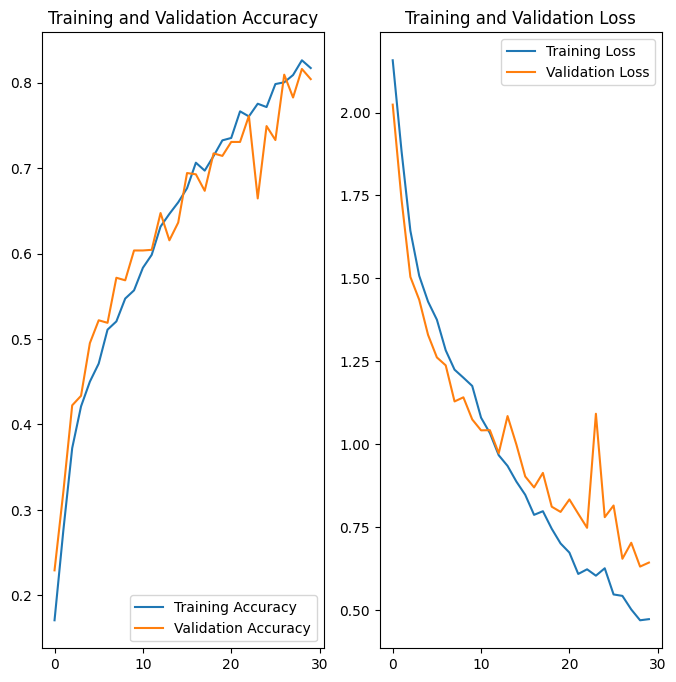

In [219]:
acc = history_3.history['accuracy']
val_acc = history_3.history['val_accuracy']

loss = history_3.history['loss']
val_loss = history_3.history['val_loss']

epochs_range = range(30)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



This model has turned out to be very good. Key pointers -
1. There is no underfitting anymore. Both training and validation accuracies have consistently climbed and gone beyond 80% in 30 epochs.
2. Both accuracies were decently close to each other throughout the training which indicates there is no overfitting. The final model has 81.7% training accuracy and similar validation accuracy of 80.4%.
3. This suggests class imbalance and lack of training data were the main problems and their resolution has helped the network to learn better and output a good model.
4. Also, both accuracies were still increasing and running for 50 epochs would have given even better results.

### Model prediction on Test image

1/1 [==============================] - 0s 12ms/step
Actual Class: melanoma
Predictive Class: melanoma


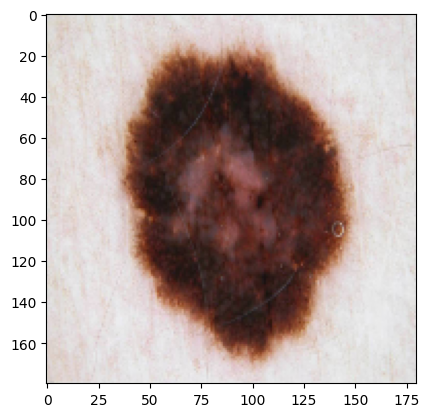

In [240]:
from glob import glob
Test_image_path = os.path.join(data_dir_test, class_names[3], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model_3.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print(f"Actual Class: {class_names[3]}" + '\n' + "Predictive Class: " + pred_class)